In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, utils
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [2]:
from pathlib import Path

dt_p = Path('data/cifar10-32')


batch_size = 128
n_channels, w, h = 3, 32, 32


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

n_labels = len(classes)


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = datasets.CIFAR10(root=f'{dt_p.absolute()}/train', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
testset = datasets.CIFAR10(root=f'{dt_p.absolute()}/test', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)



100%|██████████| 170M/170M [00:31<00:00, 5.47MB/s] 
100%|██████████| 170M/170M [00:34<00:00, 4.88MB/s] 


In [3]:

# model = nn.Sequential(
#     nn.Conv2d(
#         in_channels=3,
#         out_channels=6,
#         kernel_size=5
#     ),
#     nn.LeakyReLU(),
#      nn.Conv2d(
#         in_channels=6,
#         out_channels=16,
#         kernel_size=5
#     ),
#     nn.LeakyReLU(),
#      nn.Conv2d(
#         in_channels=16,
#         out_channels=16,
#         kernel_size=5
#     ),
#     nn.LeakyReLU(),
#     nn.Flatten(1),
#     nn.Linear(
#         5*5*16*16,
#         256),
#     nn.Linear(
#         256,
#         n_labels),
#     nn.Softmax(dim=1)
# )

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 4, padding=1)
        self.conv1b = nn.Conv2d(6, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv2b = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 5 * 5, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, n_labels)
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1b(F.leaky_relu(self.conv1(x)))))
        x = self.pool(F.leaky_relu(self.conv2b(F.leaky_relu(self.conv2(x)))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.dropout(self.fc2(x)))
        x = self.dropout(self.fc3(x))
        return self.softmax(x)	
    
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Playing on {device}")

Playing on mps


In [4]:
model = Net()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
adam = torch.optim.AdamW(model.parameters(), lr=0.001)

  1%|          | 1/100 [00:15<25:58, 15.75s/it]

Epoch 0: 2.1329703330993652


 11%|█         | 11/100 [01:20<09:23,  6.33s/it]

Epoch 10: 1.9321829080581665


 21%|██        | 21/100 [02:23<08:25,  6.40s/it]

Epoch 20: 1.7980363368988037


 31%|███       | 31/100 [03:25<07:09,  6.23s/it]

Epoch 30: 1.8043193817138672


 41%|████      | 41/100 [04:27<06:03,  6.16s/it]

Epoch 40: 1.7769874334335327


 51%|█████     | 51/100 [05:29<05:06,  6.26s/it]

Epoch 50: 1.772721529006958


 61%|██████    | 61/100 [06:31<04:00,  6.15s/it]

Epoch 60: 1.7165310382843018


 71%|███████   | 71/100 [07:34<03:11,  6.60s/it]

Epoch 70: 1.8143978118896484


 81%|████████  | 81/100 [08:38<02:00,  6.35s/it]

Epoch 80: 1.6918611526489258


 91%|█████████ | 91/100 [09:41<00:56,  6.33s/it]

Epoch 90: 1.785255789756775


100%|██████████| 100/100 [10:38<00:00,  6.38s/it]


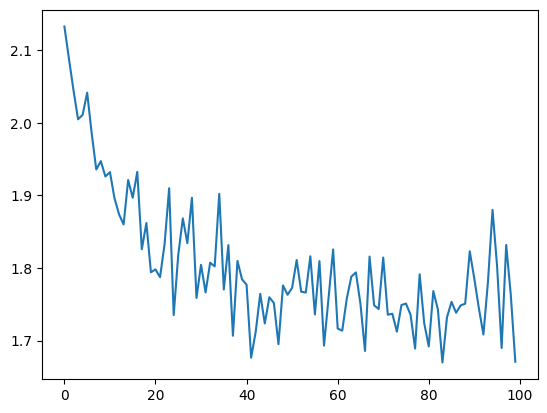

In [6]:
import time
losses = []

for e in tqdm(range(100)):
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)
        labels_hat_dist = model(images)
        adam.zero_grad()
        loss = criterion(labels_hat_dist, labels)
        loss.backward()
        adam.step()
    losses.append(loss.item())
    if e % 10 == 0:
        print(f"Epoch {e}: {loss.item()}")

plt.plot(losses)
plt.show()

PATH = f'models/{time.strftime("%m%d-%H%M%S")}.pth'
torch.save(model.state_dict(), PATH)


## Direction Sensitivity Estimation
This section aims to experiment with the first of the two tasks [(Papernot et al., 2016)](https://arxiv.org/abs/1511.04508): Direction Sensitivity Estimation. Given a sample $X$ we want to test a trained model $F$ on perturbated version of the sample (i.e. $\delta X$) to find the dimensions of $X$ that will produce expected adversarial behavior (misclassification) with the *smallest* perturbation. We formalize the problem as a linear program:
$$\arg\min_{\delta X}||\delta X|| \text{ s.t. } F(X+\delta X) = Y^*$$
where $Y^*$ is the adverserial class indicator vector. Following [(Goodfellow et al., 2014)](https://arxiv.org/pdf/1412.6572) we calculate the sign of the gradient (i.e. `step = images.grad.sign()`) and after defining a perturbation of $\delta = 0.2$ and calculate the loss for both vanilla and perturbated sample to study the loss.

In [7]:

images, labels = next(iter(testloader))
images = images.to(device)
labels = labels.to(device)

# Inside train loop
images.requires_grad = True
labels_hat_dist = model(images)
loss = criterion(labels_hat_dist, labels)
loss.backward()

print("Original loss", loss.item())


step = images.grad.sign()
perturbed_image = images + 0.2*step
perturbed_image = torch.clamp(perturbed_image, 0, 1)

labels_hat_dist = model(perturbed_image)
loss = criterion(labels_hat_dist, labels)
print("Adv loss", loss.item())

Original loss 1.8882900476455688
Adv loss 2.1891942024230957


GroundTruth:  cat   car   car   plane deer  cat   ship  truck
Predicted:  deer  bird  ship  plane deer  cat   ship  deer 
Averserial:  deer  dog   ship  plane deer  dog   car   deer 
Attack:  errr errr errr fail fail succ succ errr


Delta loss: 0.10409688949584961
	Original loss: 2.113348960876465
	Adversarial loss: 2.2174458503723145


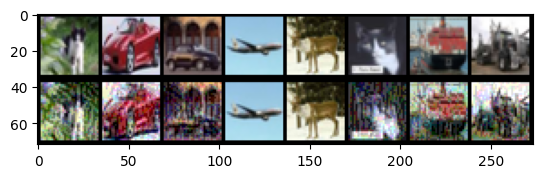

In [19]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

images = images / 2 + 0.5

limit = 120

losses = []

grid = utils.make_grid(images[:(len(labels)-limit)])
# print images

gt = [f'{classes[labels[j]]:5s}'
                              for j in range(len(labels)-(limit))]

print('GroundTruth: ', ' '.join(gt))

net = model
#net.load_state_dict(torch.load(PATH, weights_only=True))

images, labels = images.to(device), labels.to(device)

images.requires_grad = True

outputs = net(images)
loss = criterion(outputs, labels)
loss.backward()

losses.append(loss.item())

_, predicted = torch.max(outputs, 1)

org = [f'{classes[predicted[j]]:5s}'
                              for j in range(len(labels)-(limit))]

print('Predicted: ', ' '.join(org))

step = images.grad.sign()

perturbed_image = images + 0.1*step
perturbed_image = torch.clamp(perturbed_image, 0, 1)

grid_n = utils.make_grid(perturbed_image[:(len(labels)-limit)])

grod = np.concatenate((np.transpose(grid, (1, 2, 0)),np.transpose(grid_n.cpu(), (1, 2, 0))))
# print images
plt.imshow(grod)


labels_hat_dist = model(perturbed_image)
loss = criterion(labels_hat_dist, labels)

losses.append(loss.item())

_, predicted = torch.max(labels_hat_dist, 1)

adv = [f'{classes[predicted[j]]:5s}'
                              for j in range(len(labels)-(limit))]


print('Averserial: ', ' '.join(adv))





res = []
for o, p, a in zip(org, gt, adv):
    if o != p:
        res.append('errr')
    elif o == p and o != a:
        res.append('succ')
    else:
        res.append('fail')

print(f'Attack: ', ' '.join(res))
print('\n')
print(f'Delta loss: {np.abs(losses[0]-losses[1])}\n\tOriginal loss: {losses[0]}\n\tAdversarial loss: {losses[1]}')

In [9]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
accuracies = []
with torch.no_grad():
    for _ in tqdm(range(10)):
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracies.append(100 * correct / total)

print(f'Accuracy of the network on the 10000 test images: {np.mean(accuracies):.3f} %')

100%|██████████| 10/10 [00:11<00:00,  1.13s/it]

Accuracy of the network on the 10000 test images: 60.229 %
